In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Custom functions 

In [2]:
import requests
import json
def get_pgs_anno_from_catalog(pgs_id: str) -> str | None:
    url = f'https://www.pgscatalog.org/rest/score/{pgs_id}'
    response = requests.get(url)
    anno = response.json()
    if 'trait_reported' in anno:
        return anno['trait_reported']
    elif 'description' in anno:
        return anno['description']
    else:
        return ''

def get_features_anno(df):
    return {
        col: get_pgs_anno_from_catalog(col.split('_')[0])
        for col in df.columns
    }

def top_n_corr_with_anno(X, y, n: int, plt_width=10, plt_height=6):
    corr = X.corrwith(y)
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(n).index
    top_features_names = [
        pgs.split('_')[0] + ' ' + get_pgs_anno_from_catalog(pgs.split('_')[0])
        for pgs in top_features
    ]
    plt.figure(figsize=(plt_width, plt_height))
    sns.barplot(x=abs_corr[top_features], y=top_features_names)
    plt.xlabel('Absolute Correlation with BMI')
    plt.ylabel('Features')
    plt.title(f'Top {n} Features Correlated with BMI')
    plt.show()

def reduce_to_top_n_correlated(X, y, n):
    corr = X.corrwith(y)
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(n).index
    return X[top_features]

## Save PGS Meta information 

In [3]:
def fetch_pgs_catalog_metadata(f='pgs_meta.json'):
    initial_url = 'https://www.pgscatalog.org/rest/score/all'
    full_meta = []

    url = initial_url
    page=1
    while url:
        print(f"Processing page {page}")
        response = requests.get(url)
        
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}")
            break
       
        data = response.json()
        scores = data.get('results', [])
        full_meta.extend(scores)
    
        if 'next' in data and data['next']:
            page+=1
            url = data.get('next')
        else:
            break  # No more pages, exit the loop
    print(f"Total number of scores fetched: {len(full_meta)}")
    return full_meta

## Local Metadata functions

In [4]:
def read_pgs_meta(file='pgs_meta.json'):
    with open(file, 'r') as f:
        meta = json.load(f)
        return meta

def create_pgs_meta_dict(file='pgs_meta.json'):
    with open(file, 'r') as f:
        meta = json.load(f)
        id_meta_dict = {}
        for pgs in meta:
            id_meta_dict[pgs.get('id')] = pgs
        return id_meta_dict

def get_id_trait_dict(meta=None):
    if meta is None:
        meta = read_pgs_meta()
    id_trait = {}
    for pgs in meta:
        id_trait[pgs.get('id')] = pgs.get('trait_reported')
    return id_trait

def get_pgs_trait(pgs_id):
    meta = get_id_trait_dict()
    return meta[pgs_id]

def annot_pgs_cols(df):
    meta = get_id_trait_dict()
    anno = {}
    for col in list(df.columns):
        pgs = col.split('_')[0]
        if pgs.startswith('PGS'):
            anno[col] = meta[pgs]
    return anno

def get_pgs_meta(pgs_id, id_meta_dict=None):
    
    if id_meta_dict is None:
        id_meta_dict = create_pgs_meta_dict()
    return id_meta_dict[pgs_id]

## Meta based filtration 

In [5]:
def filter_by_ancestry(df, ancestry, threshold):
    pgs_columns = [col for col in df.columns if col.startswith('PGS')]
    non_pgs_columns = list(set(df.columns) - set(pgs_columns))

    id_meta = create_pgs_meta_dict()

    final_columns = []

    for col in pgs_columns:
        pgs_id = col.split('_')[0]
        ancestry_info = id_meta[pgs_id]['ancestry_distribution']
        if 'dev' in ancestry_info:
            dist = ancestry_info['dev']['dist']
        
        elif 'eval' in ancestry_info:
            dist = ancestry_info['eval']['dist']
        
        elif 'gwas' in ancestry_info:
            dist = ancestry_info['gwas']['dist']
        else:
            trait = id_meta[pgs_id]['trait_reported']
            print(f'No ancestry distribution info found for {pgs_id} ({trait})')
            continue
        if ancestry in dist and dist[ancestry] >= threshold:
            final_columns.append(col)
    final_columns.extend(non_pgs_columns)
    return df[final_columns]

# Models 

## Prepare VCF data

In [6]:
vcf = pd.read_csv('SupplementaryFile1.vcf', sep='\t', skiprows=87)

In [7]:
vcf.rename(columns={vcf.columns[0]: 'CHROM'}, inplace=True)
vcf['VAR'] = vcf.apply(lambda row: f"{row['CHROM']}_{row['POS']}_{row['REF']}_{row['ALT']}", axis=1)
genotype_encoding = {'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2, './.': np.nan}
vcf = vcf.replace(genotype_encoding)
vcf.drop(columns=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], inplace=True )

/tmp/ipykernel_101398/4179733911.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vcf = vcf.replace(genotype_encoding)


In [8]:
vcf_pivot = vcf.set_index('VAR').T.reset_index().rename(columns={'index': 'Sample'})

In [27]:
vcf_pivot

VAR,Sample,1_1708801_A_G,1_2077409_A_G,1_2224836_G_A,1_2265969_T_G,1_2286127_G_C,1_2444414_G_A,1_2847985_A_T,1_3038530_T_C,1_3316756_G_A,...,22_44543336_G_A,22_45838646_T_C,22_45996298_A_G,22_46236425_G_A,22_46454208_G_A,22_46482948_T_C,22_46615376_G_A,22_47156703_T_C,22_48875699_C_T,22_50943423_G_A
0,1112261,2,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,1113645,0,2,0,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1112646,1,1,0,1,1,1,0,1,2,...,0,0,0,1,0,0,0,1,1,0
3,E20B1113276,2,0,1,1,0,2,2,1,2,...,0,1,0,1,0,0,0,0,1,0
4,E21B1113880,2,2,2,1,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11748,NNR00007496,0,0,0,2,0,1,0,0,1,...,0,1,0,1,0,1,0,0,0,0
11749,NNR00007627,1,2,2,2,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2,0
11750,NNR00007497,1,1,0,1,1,0,0,1,2,...,0,0,0,1,0,0,0,0,1,0
11751,NNR00007628,1,1,0,0,1,1,0,2,0,...,0,0,0,1,1,0,1,0,1,0


## Merge VCF data with metadata

In [9]:
meta = pd.read_excel('Table_2.XLSX')
meta = meta[meta['bmi'].notna()]
meta['ID'] = meta['ID'].astype(str).str.strip()
vcf_pivot_filt =  vcf_pivot[vcf_pivot['Sample'].isin(meta['ID'])]

In [10]:
vcf_pivot_filt.shape[0] == meta.shape[0]

True

In [11]:
df_final = vcf_pivot_filt.merge(meta, left_on='Sample', right_on='ID', how='inner')

In [12]:
sum(df_final['Sample'] == df_final['ID']) == df_final.shape[0]

True

In [39]:
df_final

,Sample,1_1708801_A_G,1_2077409_A_G,1_2224836_G_A,1_2265969_T_G,1_2286127_G_C,1_2444414_G_A,1_2847985_A_T,1_3038530_T_C,1_3316756_G_A,...,height,age,sex,bmi,ethnicity,source,zscore_BMI_clasters,zscore_height_clasters,PRS_by_claters_height,PRS_by_claters_bmi
0,1112261,2,1,1,1,1,1,0,1,1,...,183.0,37.0,M,31.950790,Rus,this study,0.882407,0.611885,0.000283,-0.000028
1,1113645,0,2,0,0,1,1,1,0,0,...,180.0,43.0,M,37.037037,Rus,this study,2.269039,0.338887,0.000137,0.000430
2,E20B1113276,2,0,1,1,0,2,2,1,2,...,176.0,28.0,F,24.212293,Rus,this study,-0.309673,1.839932,0.000219,-0.000234
3,E21B1113880,2,2,2,1,0,0,1,0,0,...,158.0,37.0,F,18.827111,Rus,this study,-1.290870,-1.268454,0.000170,0.000056
4,1111111,0,1,0,2,0,1,0,1,1,...,170.0,48.0,M,24.913495,Rus,this study,-0.734554,-1.352854,0.000444,-0.000179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8549,NNR00007496,0,0,0,2,0,1,0,0,1,...,163.0,43.0,F,31.992171,Rus,this study,1.137877,-0.425294,0.000164,0.000119
8550,NNR00007627,1,2,2,2,0,0,0,1,0,...,181.0,47.0,M,26.555966,Rus,this study,-0.189895,0.419574,0.000333,-0.000144
8551,NNR00007497,1,1,0,1,1,0,0,1,2,...,164.0,42.0,F,26.026175,Rus,this study,0.037245,-0.256662,0.000431,-0.000187
8552,NNR00007628,1,1,0,0,1,1,0,2,0,...,160.0,29.0,F,24.218750,Rus,this study,-0.296197,-0.931190,0.000114,-0.000127


# Models 

## Prepare data 

In [13]:
useless_columns = ['Sample', 'ID', 'clusters', 'weight', 'height', 'ethnicity',
       'source', 'zscore_BMI_clasters', 'zscore_height_clasters',
       'PRS_by_claters_height', 'PRS_by_claters_bmi' ]
df = df_final.drop(useless_columns, axis=1)
df = pd.get_dummies(df, columns=['sex'], drop_first=True)
df

,1_1708801_A_G,1_2077409_A_G,1_2224836_G_A,1_2265969_T_G,1_2286127_G_C,1_2444414_G_A,1_2847985_A_T,1_3038530_T_C,1_3316756_G_A,1_3766286_G_T,...,22_46236425_G_A,22_46454208_G_A,22_46482948_T_C,22_46615376_G_A,22_47156703_T_C,22_48875699_C_T,22_50943423_G_A,age,bmi,sex_M
0,2,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,1,0,37.0,31.950790,True
1,0,2,0,0,1,1,1,0,0,0,...,1,0,0,0,0,0,0,43.0,37.037037,True
2,2,0,1,1,0,2,2,1,2,2,...,1,0,0,0,0,1,0,28.0,24.212293,False
3,2,2,2,1,0,0,1,0,0,2,...,1,0,0,0,0,0,1,37.0,18.827111,False
4,0,1,0,2,0,1,0,1,1,1,...,1,0,2,0,1,1,0,48.0,24.913495,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8549,0,0,0,2,0,1,0,0,1,1,...,1,0,1,0,0,0,0,43.0,31.992171,False
8550,1,2,2,2,0,0,0,1,0,1,...,1,0,0,0,0,2,0,47.0,26.555966,True
8551,1,1,0,1,1,0,0,1,2,2,...,1,0,0,0,0,1,0,42.0,26.026175,False
8552,1,1,0,0,1,1,0,2,0,1,...,1,1,0,1,0,1,0,29.0,24.218750,False


In [18]:
X = df.drop(columns=['bmi'])
y = df['bmi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f'Trying {name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R²': r2}

# Display results
for name, metrics in results.items():
    print(f'{name}:')
    print(f"  Root Mean Squared Error (RMSE) = {metrics['RMSE']}")
    print(f"  Mean Squared Error (MSE) = {metrics['MSE']}")
    print(f"  Mean Absolute Error (MAE) = {metrics['MAE']}")
    print(f"  R-squared (R²) = {metrics['R²']}\n")

Trying Linear Regression
Trying Random Forest
Trying Gradient Boosting
Trying Support Vector Regressor
Linear Regression:
  Root Mean Squared Error (RMSE) = 390771551179.9578
  Mean Squared Error (MSE) = 1.527024052115904e+23
  Mean Absolute Error (MAE) = 17273077925.852455
  R-squared (R²) = -6.436660772618937e+21

Random Forest:
  Root Mean Squared Error (RMSE) = 4.602991217232215
  Mean Squared Error (MSE) = 21.187528145916907
  Mean Absolute Error (MAE) = 3.498748891928405
  R-squared (R²) = 0.10691039151207982

Gradient Boosting:
  Root Mean Squared Error (RMSE) = 4.5912558232647145
  Mean Squared Error (MSE) = 21.07963003466215
  Mean Absolute Error (MAE) = 3.4795236045133637
  R-squared (R²) = 0.11145847665318054

Support Vector Regressor:
  Root Mean Squared Error (RMSE) = 4.676035529508641
  Mean Squared Error (MSE) = 21.865308273227157
  Mean Absolute Error (MAE) = 3.5327538614805656
  R-squared (R²) = 0.07834083000534697



In [65]:
metrics_df = pd.DataFrame(results).T.reset_index()
metrics_df.rename(columns={'index': 'Model'}, inplace=True)
metrics_df['Model'] = metrics_df['Model'].replace({'Support Vector Regressor': 'SVR'})
metrics_df

,Model,RMSE,MSE,MAE,R²
0,Linear Regression,3.907716e+11,1.527024e+23,1.727308e+10,-6.436661e+21
1,Random Forest,4.602991e+00,2.118753e+01,3.498749e+00,1.069104e-01
2,Gradient Boosting,4.591256e+00,2.107963e+01,3.479524e+00,1.114585e-01
3,SVR,4.676036e+00,2.186531e+01,3.532754e+00,7.834083e-02


In [31]:
metrics_df.drop(0)

,Model,RMSE,R²
1,Random Forest,4.602991,0.106910
2,Gradient Boosting,4.591256,0.111458
3,SVR,4.676036,0.078341


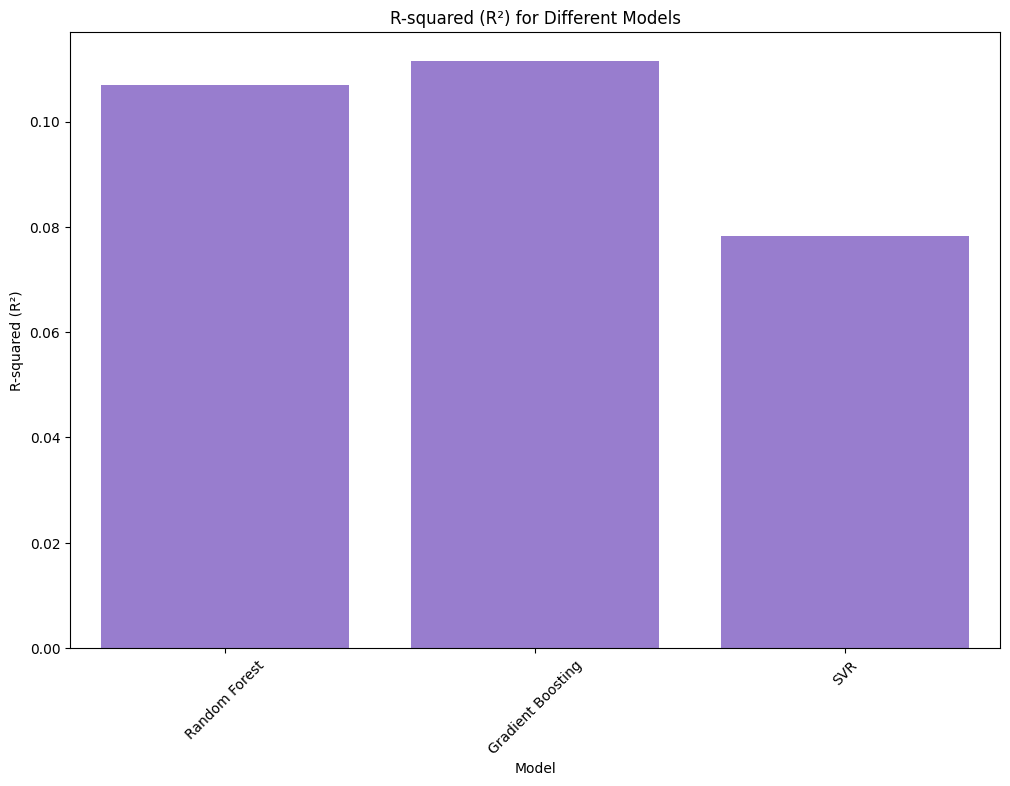

In [67]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='R²', data=metrics_df.drop(0), color='mediumpurple')
plt.xlabel('Model')
plt.ylabel('R-squared (R²)')
plt.title('R-squared (R²) for Different Models')
plt.xticks(rotation=45)
plt.savefig('gt_pred_r2.pdf', bbox_inches='tight', format='pdf')
plt.show()



In [58]:
len(feature_importances.iloc[3:]['Importance'])

4240

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = models['Random Forest'].feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(3)
other_features_sum = feature_importances.iloc[3:]['Importance'].sum()
other_features_df = pd.DataFrame({'Feature': ['Other 4240 features'], 'Importance': [other_features_sum]})

top_10_with_others = pd.concat([top_10_features, other_features_df], ignore_index=True)

top_10_with_others

,Feature,Importance
0,age,0.087599
1,sex_M,0.056482
2,1_184000875_T_C,0.001981
3,Other 4240 features,0.853938


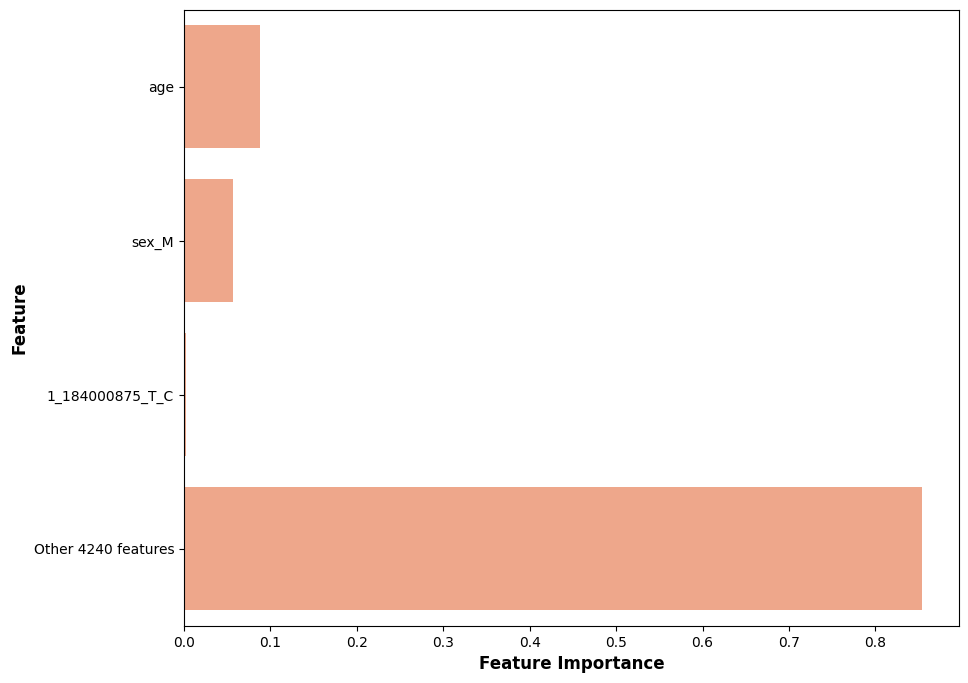

In [66]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_with_others, color='lightsalmon')
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.savefig('gt_pred_f_imp.pdf', bbox_inches='tight', format='pdf')
plt.show()

